In [1]:
import pandas as pd
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pmdarima as pm
from statsmodels.tsa import stattools

In [2]:
# load your dataset
data_dir = os.path.join(os.getcwd(), 'data_files')

target_df = pd.read_csv(os.path.join(data_dir, 'targets.csv'), parse_dates=['USAGE_DATE'], index_col='USAGE_DATE')
predictor_df = pd.read_csv(os.path.join(data_dir, 'predictors.csv'), parse_dates=['USAGE_DATE'], index_col='USAGE_DATE')
predictor_df['Holiday'] = predictor_df['Holiday'].astype(int)

df = target_df.join(predictor_df).sort_index(ascending=True)

C:\Users\JCheung1\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1434: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


721 721


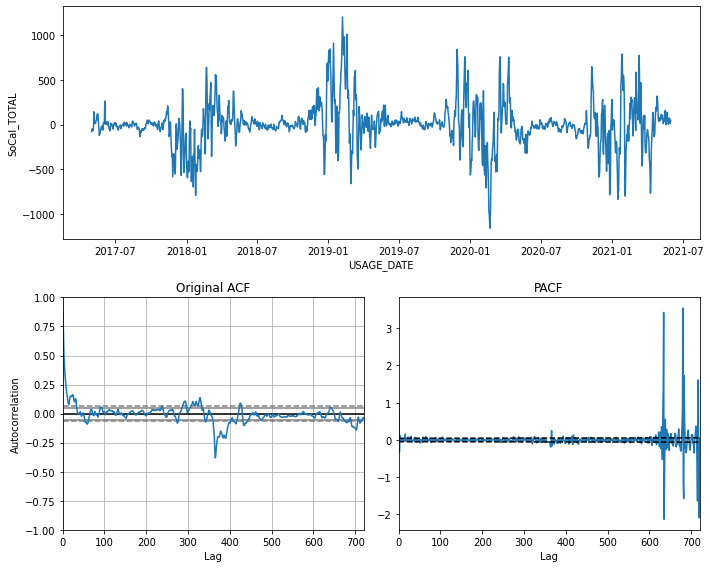

stationary if sig: 8.259619372791452e-06


In [32]:
# identify whether target series is stationary by checking acf plot

def acf_plots(data, nlags, seasonal_m):
    acf_values = []
    for k in np.arange(0,nlags+1):
        acf_values.append(data.diff(seasonal_m).dropna().autocorr(lag=k))
    acf_5cv = 1.96/np.sqrt(len(df['SoCal_TOTAL']) - np.arange(0, nlags+1))
    pacf_values = stattools.pacf(data, nlags=nlags)
    
    print(len(acf_values), len(pacf_values))
    
    fig = plt.figure(figsize=(10, 8))
    gs = GridSpec(2, 2, figure=fig)
    ax1 = fig.add_subplot(gs[0, :])
    ax2 = fig.add_subplot(gs[1, 0])
    ax3 = fig.add_subplot(gs[1, 1])

    sns.lineplot(data=data, ax=ax1)

    pd.plotting.autocorrelation_plot(data, ax=ax2)
    ax2.set_title('Original ACF'), ax2.set_ylim([-1, 1]), ax2.set_xlim([0, nlags])

    sns.lineplot(data=pacf_values, ax=ax3)
    ax3.plot(np.arange(0, nlags+1), acf_5cv, 'k--')
    ax3.plot(np.arange(0, nlags+1), acf_5cv*-1, 'k--')
    ax3.set_title('PACF'), ax3.set_xlabel('Lag'), ax3.set_xlim([0, nlags])

    plt.tight_layout(), plt.show()
    
    marks_df = pd.DataFrame({'ACF': acf_values,
                             'PACF': pacf_values,
                             '5CV': acf_5cv,})
    
    adf_p = stattools.adfuller(data)[1]
    print('stationary if sig:', adf_p)
    return marks_df

# acf_plots(df['SoCal_TOTAL']) #not sig
seasonal_diff =df['SoCal_TOTAL'].diff(365).dropna()
marks_df = acf_plots(seasonal_diff, nlags=720, seasonal_m=365)

In [45]:
np.diff(marks_df.index[marks_df['PACF']>marks_df['5CV']]).cumsum()

array([  1,   3,   4,  16,  23,  28,  30,  38,  41,  58,  62,  65,  75,
        76,  86,  89, 104, 250, 261, 275, 279, 287, 289, 290, 299, 310,
       318, 325, 326, 334, 347, 348, 366, 384, 394, 401, 405, 415, 418,
       419, 422, 423, 450, 454, 461, 475, 476, 489, 520, 566, 573, 580,
       593, 594, 601, 604, 611, 615, 618, 622, 625, 626, 629, 632, 633,
       634, 638, 641, 642, 645, 648, 649, 652, 661, 662, 663, 668, 669,
       670, 671, 677, 678, 679, 680, 683, 684, 685, 691, 692, 693, 700,
       701, 703, 709, 710, 711, 712, 716, 717, 720], dtype=int64)

In [55]:
# NOTE: Seasonal order cannot exceed 200. For daily data with yearly seasonality (i.e. m=365) 
# seasonality needs to be resolve via FFT added on top of an ARIMA process
# see note in https://robjhyndman.com/hyndsight/longseasonality/
df_test = df[df.index >= pd.to_datetime('4/15/21')] 
df_train = df[df.index < pd.to_datetime('4/15/21')]
arima_fit = ARIMA(df_train['SoCal_TOTAL'], order=(33, 0, 1), seasonal_order=(1, 1, 1, 365)).fit()
arima_fit.summary()

C:\Users\JCheung1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\JCheung1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\JCheung1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\JCheung1\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


KeyboardInterrupt: 

In [ ]:
# find D via Canova Hanson test to minimize search params for auto_arima seasonal component
pm.arima.utils.nsdiffs(df['SoCal_TOTAL'], 
                      m=365,
                      max_D=12,
                      test='ch')

In [ ]:
df_test = df[df.index >= pd.to_datetime('4/15/21')] 
df_train = df[df.index < pd.to_datetime('4/15/21')]
arima_fit = pm.auto_arima(df_train['SoCal_TOTAL'], 
                          p=30,
                          d=0,
                          q=0, 
                          seasonal=True, m=365,
                          P=5,
                          D=1, 
                          Q=0,
                          stepwise=True)
arima_fit.summary()

In [51]:
days_to_forecast = pd.date_range(start=df_train.index.max(), end = df_train.index.max() + pd.DateOffset(months=6), freq='1d')
predictions = pd.DataFrame({'ARIMA_predict': arima_fit.predict(len(days_to_forecast))})
predictions.index=days_to_forecast

compare_df = pd.concat([df_test['SoCal_TOTAL'], predictions], axis=1).rename(columns={'SoCal_TOTAL': 'Test'})
sns.lineplot(data=df_train['SoCal_TOTAL'], color='k', label='Train')
sns.lineplot(data=compare_df, )
plt.xlim([df_train.index.max() - pd.DateOffset(months=1), predictions.index.max()])
plt.show()

NotImplementedError: 

In [ ]:
pd.date_range(start=df_train.index.max(), end = df_train.index.max() + pd.DateOffset(months=3), freq='1d')

In [ ]:
# transform target data to stationary

lb_test = sm.stats.acorr_ljungbox(df[forecast_column+'_residuals'], lags=[27])

df['SoCal_TOTAL']

In [ ]:
tmp = ARIMA(df['SoCal_TOTAL'].pct_change().dropna()).fit()
tmp.summary()

In [ ]:
def objfunc(order, exog, endog):
    fit = ARIMA(endog, order, exog).fit()
    return fit.aic()

from scipy.optimize import brute
grid = (slice(1, 3, 1), slice(1, 3, 1), slice(1, 3, 1))
brute(objfunc, grid, args=(exog, endog), finish=None)